# Diagram of Shapes

This notebook documents and loads the dataset described below.

Dataset: `data.xlsx`
Sheets: `Shapes`, `Objects`, `Tangency`

### **Shapes**
- `shape_code` — *choice* `{ellipse, rectangle, pentagon, hexagon, triangle}` — **PRIMARY KEY**
- `color` — color name (string)

### **Objects**
- `id` — unique identifier — **PRIMARY KEY**
- `shape_code` — **FOREIGN KEY** → `Shapes(shape_code)`
- `x` — real number (x coordinate)
- `y` — real number (y coordinate)
- `radius` — real number (radius of the minimum enclosing circle of the given shape; used to size objects)

### **Tangency**
- `id` — unique identifier — **PRIMARY KEY**
- `object_id` — **FOREIGN KEY** → `Objects(id)`
- `target_type` — *choice* `{axis, object}`
- `target_axis` — *choice* `{x, y}` — only if `target_type = axis`
- `target_object_id` — **FOREIGN KEY** → `Objects(id)` — only if `target_type = object`
- `contains` — boolean — indicates the target is fully inside the given object

In [609]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Ellipse, Circle, Rectangle, RegularPolygon
from matplotlib.ticker import MultipleLocator


## 1) Load data from the dataset


In [610]:
DATASET_PATH = 'data.xlsx'

shapes = pd.read_excel(DATASET_PATH, sheet_name='Shapes')
objects = pd.read_excel(DATASET_PATH, sheet_name='Objects')
tangency = pd.read_excel(DATASET_PATH, sheet_name='Tangency')

print('Shapes (first 5):')
display(shapes.head(5))
print('\nObjects (first 5):')
display(objects.head(5))
print('\nTangency (first 5):')
display(tangency.head(5))


Shapes (first 5):


,shape_code,color
0,ellipse,blue
1,circle,purple
2,rectangle,lightblue
3,pentagon,violet
4,hexagon,yellow



Objects (first 5):


,id,shape_code,x,y,radius
0,1,ellipse,8.0,0.0,4.5
1,2,ellipse,3.5,0.0,2.5
2,3,circle,-8.0,0.0,1.5
3,4,circle,0.0,4.7,1.2
4,5,rectangle,0.0,-8.2,1.5



Tangency (first 5):


,id,object_id,target_type,target_axis,target_object_id,contains
0,1,1,axis,x,NaN,False
1,2,2,axis,x,NaN,False
2,3,3,axis,x,NaN,False
3,4,4,axis,y,NaN,False
4,5,5,axis,y,NaN,False


## 2) Count objects by shape

In [611]:
obj_shapes = objects.merge(shapes, on='shape_code', how='left')
counts = (obj_shapes.groupby('shape_code', dropna=False)['id'].count().reset_index(name='Count'))\
            .rename(columns={'shape_code': 'Shape Name'})

print(counts.to_string(index=False))


Shape Name  Count
    circle      2
   ellipse      2
   hexagon      1
  pentagon      3
 rectangle      3
  triangle      1



## 3) Plot counts


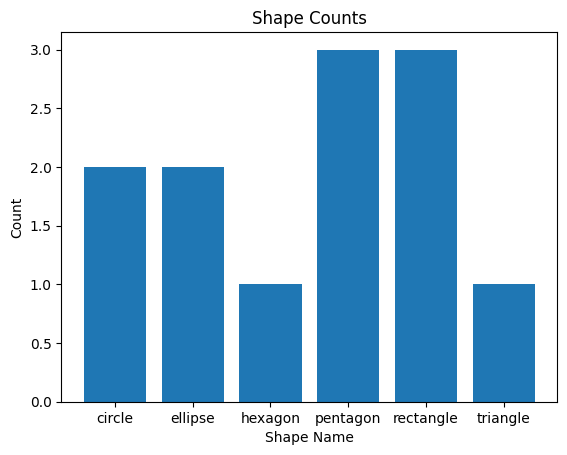

In [612]:
plt.figure()
plt.bar(counts['Shape Name'], counts['Count'])
plt.title('Shape Counts')
plt.xlabel('Shape Name')
plt.ylabel('Count')
plt.show()


## 4) Build unified table


In [613]:
base = objects.merge(shapes, on='shape_code', how='left', suffixes=('', '_s'))
unified = base.merge(tangency, left_on='id', right_on='object_id', how='left', suffixes=('','_t'))
columns = ['id','shape_code','color','x','y','radius','target_type','target_axis','target_object_id', 'contains']
preview = unified[columns].head(15)
display(preview)

,id,shape_code,color,x,y,radius,target_type,target_axis,target_object_id,contains
0,1,ellipse,blue,8.0,0.0,4.5,axis,x,NaN,False
1,1,ellipse,blue,8.0,0.0,4.5,object,NaN,2.0,False
2,1,ellipse,blue,8.0,0.0,4.5,object,NaN,9.0,False
3,2,ellipse,blue,3.5,0.0,2.5,axis,x,NaN,False
4,2,ellipse,blue,3.5,0.0,2.5,object,NaN,1.0,False
5,3,circle,purple,-8.0,0.0,1.5,axis,x,NaN,False
6,3,circle,purple,-8.0,0.0,1.5,object,NaN,10.0,False
7,4,circle,purple,0.0,4.7,1.2,axis,y,NaN,False
8,4,circle,purple,0.0,4.7,1.2,object,NaN,8.0,False
9,5,rectangle,lightblue,0.0,-8.2,1.5,axis,y,NaN,False


## 5) Plot diagram

In [614]:
def draw_row(ax, row):
    name  = row['shape_code']
    color = row.get('color')
    x, y, r = row['x'], row['y'], row['radius']

    def rgba(color):
        t = 0.5 # transparency
        try:
            return to_rgba(color, t)
        except ValueError:
            return to_rgba("white", t)

    if name == 'ellipse':
        ax.add_patch(Ellipse((x, y), width=2*r, height=r*2/3, facecolor=rgba(color)))
    if name == 'circle':
        ax.add_patch(Circle((x, y), r, facecolor=rgba(color)))
    if name == 'rectangle':
        ax.add_patch(Rectangle((x-r, y-r), 2*r, 2*r, facecolor=rgba(color)))
    if name == 'triangle':
        ax.add_patch(RegularPolygon((x, y), 3, radius=r, facecolor=rgba(color)))
    if name == 'pentagon':
        ax.add_patch(RegularPolygon((x, y), 5, radius=r, facecolor=rgba(color)))
    if name == 'hexagon':
        ax.add_patch(RegularPolygon((x, y), 6, radius=r, facecolor=rgba(color)))
    
    # ax.text(x, y, row['id'], ha='center', va='center', fontsize=8)


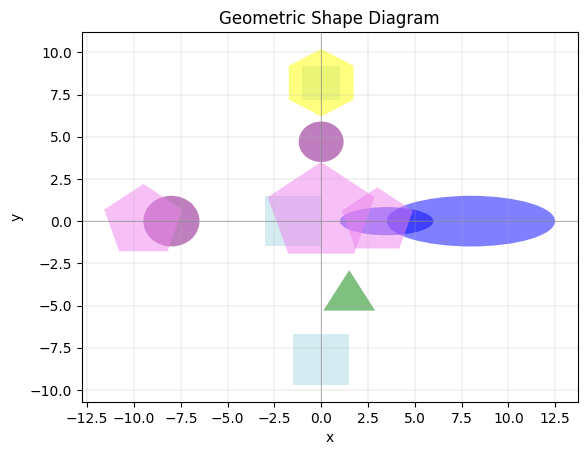

In [615]:
figure, axes = plt.subplots()
axes.axhline(0, color='grey', linewidth=0.4)
axes.axvline(0, color='grey', linewidth=0.4)
axes.grid(True, linewidth=0.2)

for _, r in obj_shapes.iterrows():
    draw_row(axes, r)

axes.autoscale_view()
axes.xaxis.set_major_locator(MultipleLocator(2.5))
axes.yaxis.set_major_locator(MultipleLocator(2.5))

axes.set_xlabel('x')
axes.set_ylabel('y')
axes.set_title('Geometric Shape Diagram')
plt.show()